# Teacher Forcing Encoder Decoder

To see basic encoder decoder arch read the notebook `basicEncoderDecoder.ipynb` in this direcotry. This notebook will continue on that basic encoderDecoder and will add Teacher Forcing to it.

ref:

https://colab.research.google.com/drive/1TNUB8vsZimVZl_wktWS1ac4wyw8kaNLW?usp=sharing

In [1]:
import helpers
import tensorflow as tf
import numpy as np

from random import randint
from numpy import array
from numpy import argmax
from numpy import array

from tensorflow.keras import models
from numpy import array_equal
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
import pdb

In [2]:
helpers.check_gpu_tensorflow()

is CUDA available: True
Tensorflow version  2.6.0
Keras version  2.6.0


In [12]:
#### define the functions we need

# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]


def get_encoder_triple(time_steps, vocabulary_size, verbose=False):
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    encoder_in = sequence_in.copy()

    decoder_out = sequence_in[::-1] # reverse order
    decoder_in = decoder_out.copy()
    decoder_in.insert(0,0) # insert 0 at index 0
    decoder_in.pop() # remove the last element
    
    
    # one hot encode
    X_encoder_in = one_hot_encode(encoder_in, vocabulary_size)
    X_decoder_in = one_hot_encode(decoder_in, vocabulary_size)
    y_decoder_out = one_hot_encode(decoder_out, vocabulary_size)
    # reshape as 3D
    X_encoder_in = X_encoder_in.reshape((1, X_encoder_in.shape[0], X_encoder_in.shape[1]))
    X_decoder_in = X_decoder_in.reshape((1, X_decoder_in.shape[0], X_decoder_in.shape[1]))
    y_decoder_out = y_decoder_out.reshape((1, y_decoder_out.shape[0], y_decoder_out.shape[1]))
    
    if(verbose):
        print('\nSample X_encoder_in X_decoder_in and y_decoder_out')
        print('\nIn raw format:')
        print('X_encoder_in=%s, X_decoder_in=%s, y_decoder_out=%s' % 
              (one_hot_decode(X_encoder_in[0]), one_hot_decode(X_decoder_in[0]), 
               one_hot_decode(y_decoder_out[0])))
        print('\nIn one_hot_encoded format:')
        print('X_encoder_in=%s' % (X_encoder_in[0]))
        print('X_decoder_in=%s' % (X_decoder_in[0]))
        print('y_decoder_out=%s' % (y_decoder_out[0]))
    return [array(X_encoder_in), array(X_decoder_in), array(y_decoder_out)]
    
def create_encoder_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):

    X_encoder_in = list()
    X_decoder_in = list()
    y_decoder_out = list()

    for _ in range(train_size):
        triple=get_encoder_triple(time_steps,vocabulary_size) 
        X_encoder_in.append(triple[0])
        X_decoder_in.append(triple[1])
        y_decoder_out.append(triple[2])

    X_encoder_in= array(X_encoder_in).squeeze()
    X_decoder_in= array(X_decoder_in).squeeze()
    y_decoder_out= array(y_decoder_out).squeeze()
    if(verbose):
        print('\nGenerated sequence datasets as follows')
        print('X_encoder_in.shape: ', X_encoder_in.shape)
        print('X_decoder_in.shape: ', X_decoder_in.shape)
        print('y_decoder_out.shape: ', y_decoder_out.shape)
        print('Sample sequences in raw format:')

        print('X_encoder_in: \n', one_hot_decode(X_encoder_in[0]))
        print('X_decoder_in: \n', one_hot_decode(X_decoder_in[0]))
        print('y_decoder_out: \n',one_hot_decode(y_decoder_out[0]))

        print('Sample sequences in one-hot encoded format:')
        print('X_encoder_in: \n', X_encoder_in[0])
        print('X_decoder_in: \n', X_decoder_in[0])
        print('y_decoder_out: \n', y_decoder_out[0])

    return X_encoder_in,X_decoder_in, y_decoder_out

def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_loss, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
  
	# spot check some examples
	space = 3*len(one_hot_decode(y_test[0]))
	print('10 examples from test data...')
	print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
	      'Predicted',' '*(space-5) ,'T/F')
	correct =0 
	sampleNo =  10

	predicted= model.predict(X_test[:sampleNo], batch_size=batch_size)
	for sample in range(0,sampleNo):
		if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
			correct+=1
		print( one_hot_decode(X_test[0][sample]), ' ', 
					one_hot_decode(y_test[sample]),' ', one_hot_decode(predicted[sample]),
					' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
	print('Accuracy: ', correct/sampleNo)
	



In [4]:
n_timesteps_in =   4
n_features = 10
X,y = get_reversed_pairs(n_timesteps_in,  n_features, verbose=True)
train_size= 2000
test_size = 200
X_train, y_train , X_test, y_test=create_dataset(train_size, test_size,
                                                 n_timesteps_in,n_features ,verbose=True)


LSTMoutputDimension = 16


Sample X and y

In raw format:
X=[4, 0, 8, 6], y=[6, 8, 0, 4]

In one_hot_encoded format:
X=[[0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]]
y=[[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]

Generated sequence datasets as follows
X_train.shape:  (2000, 4, 10) y_train.shape:  (2000, 4, 10)
X_test.shape:  (200, 4, 10) y_test.shape:  (200, 4, 10)


In [5]:

encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
encoder_lstm = LSTM(LSTMoutputDimension, return_state=True, name='encoder_lstm')

_, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]



decoder_inputs = Input(shape=(None, n_features), name='decoder_inputs')
decoder_lstm = LSTM(LSTMoutputDimension, return_sequences=True,
                    return_state=True, name='decoder_lstm')

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

model_encoder_training = Model([encoder_inputs, decoder_inputs], decoder_outputs,
                                  name='model_encoder_training')

Model: "model_encoder_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 16), (None,  1728        encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 16), ( 1728        decoder_inputs[0][0]             
                                                                 encoder_lstm

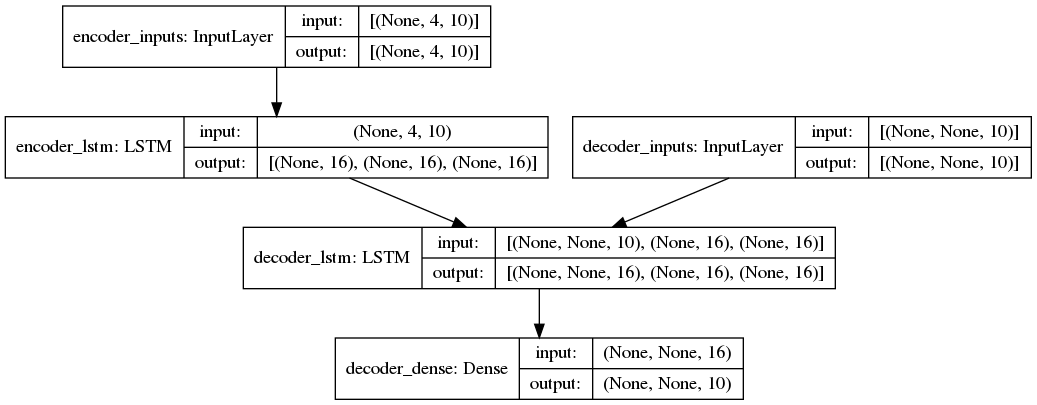

In [6]:
model_encoder_training.compile(optimizer='adam', loss='categorical_crossentropy',
                               metrics=['accuracy'])
model_encoder_training.summary()
plot_model(model_encoder_training, show_shapes=True)

In [13]:
encoder_input_data, decoder_input_data, decoder_predicted_data=\
create_encoder_dataset(train_size, test_size, n_timesteps_in,n_features , verbose=True)


Generated sequence datasets as follows
X_encoder_in.shape:  (2000, 4, 10)
X_decoder_in.shape:  (2000, 4, 10)
y_decoder_out.shape:  (2000, 4, 10)
Sample sequences in raw format:
X_encoder_in: 
 [8, 0, 5, 7]
X_decoder_in: 
 [0, 7, 5, 0]
y_decoder_out: 
 [7, 5, 0, 8]
Sample sequences in one-hot encoded format:
X_encoder_in: 
 [[0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]]
X_decoder_in: 
 [[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]
y_decoder_out: 
 [[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]]


In [14]:
model_encoder_training.fit([encoder_input_data, decoder_input_data], decoder_predicted_data,
          batch_size=32,
          epochs=50,
          validation_split=0.2)

Epoch 1/50
50/50 [==============================] - 4s 16ms/step - loss: 2.2848 - accuracy: 0.1744 - val_loss: 2.2659 - val_accuracy: 0.2325
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 2.2281 - accuracy: 0.2686 - val_loss: 2.1826 - val_accuracy: 0.2775
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 2.0793 - accuracy: 0.2909 - val_loss: 1.9849 - val_accuracy: 0.3144
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 1.8539 - accuracy: 0.3395 - val_loss: 1.7544 - val_accuracy: 0.3619
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 1.6486 - accuracy: 0.3948 - val_loss: 1.5696 - val_accuracy: 0.4075
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 1.4853 - accuracy: 0.4284 - val_loss: 1.4344 - val_accuracy: 0.4575
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 1.3603 - accuracy: 0.4731 - val_loss: 1.3141 - val_accuracy: 0.5081
Epoch 8/50
50/50 [=

training for  50  epochs begins with EarlyStopping(monitor= val_loss, patience= 5 )....
Epoch 1/50
57/57 - 1s - loss: 0.0427 - accuracy: 0.9997 - val_loss: 0.0484 - val_accuracy: 0.9987
Epoch 2/50
57/57 - 0s - loss: 0.0410 - accuracy: 0.9997 - val_loss: 0.0467 - val_accuracy: 0.9975
Epoch 3/50
57/57 - 0s - loss: 0.0390 - accuracy: 0.9999 - val_loss: 0.0443 - val_accuracy: 0.9975
Epoch 4/50
57/57 - 0s - loss: 0.0372 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9987
Epoch 5/50
57/57 - 0s - loss: 0.0354 - accuracy: 1.0000 - val_loss: 0.0408 - val_accuracy: 1.0000
Epoch 6/50
57/57 - 0s - loss: 0.0343 - accuracy: 1.0000 - val_loss: 0.0387 - val_accuracy: 0.9987
Epoch 7/50
57/57 - 0s - loss: 0.0323 - accuracy: 1.0000 - val_loss: 0.0363 - val_accuracy: 1.0000
Epoch 8/50
57/57 - 0s - loss: 0.0308 - accuracy: 1.0000 - val_loss: 0.0359 - val_accuracy: 1.0000
Epoch 9/50
57/57 - 0s - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.0341 - val_accuracy: 1.0000
Epoch 10/50
57/57 - 0s - loss:

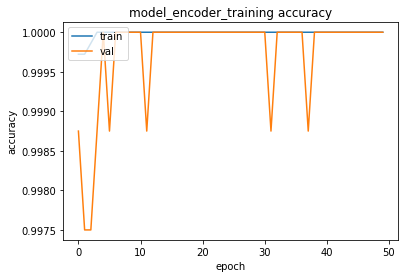

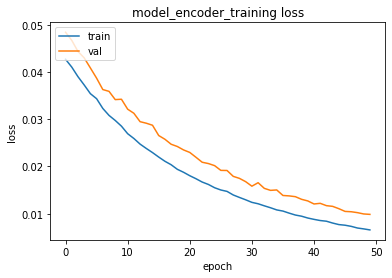

10 examples from test data...
Input          Expected       Predicted         T/F
[8, 0, 5, 7]   [7, 5, 0, 8]   [7, 5, 0, 8]   True
[2, 4, 3, 4]   [4, 3, 4, 2]   [4, 3, 4, 2]   True
[1, 6, 8, 1]   [1, 8, 6, 1]   [1, 8, 6, 1]   True
[9, 7, 8, 7]   [7, 8, 7, 9]   [7, 8, 7, 9]   True
[8, 9, 7, 9]   [9, 7, 9, 8]   [9, 7, 9, 8]   True
[5, 9, 1, 3]   [3, 1, 9, 5]   [3, 1, 9, 5]   True
[4, 4, 7, 7]   [7, 7, 4, 4]   [7, 7, 4, 4]   True
[2, 2, 9, 0]   [0, 9, 2, 2]   [0, 9, 2, 2]   True
[6, 1, 7, 2]   [2, 7, 1, 6]   [2, 7, 1, 6]   True
[3, 0, 7, 3]   [3, 7, 0, 3]   [3, 7, 0, 3]   True
Accuracy:  1.0


In [15]:
train_test(model_encoder_training, [encoder_input_data, decoder_input_data], decoder_predicted_data , [encoder_input_data, decoder_input_data], decoder_predicted_data, epochs=50, batch_size=32, patience=5,verbose=2)

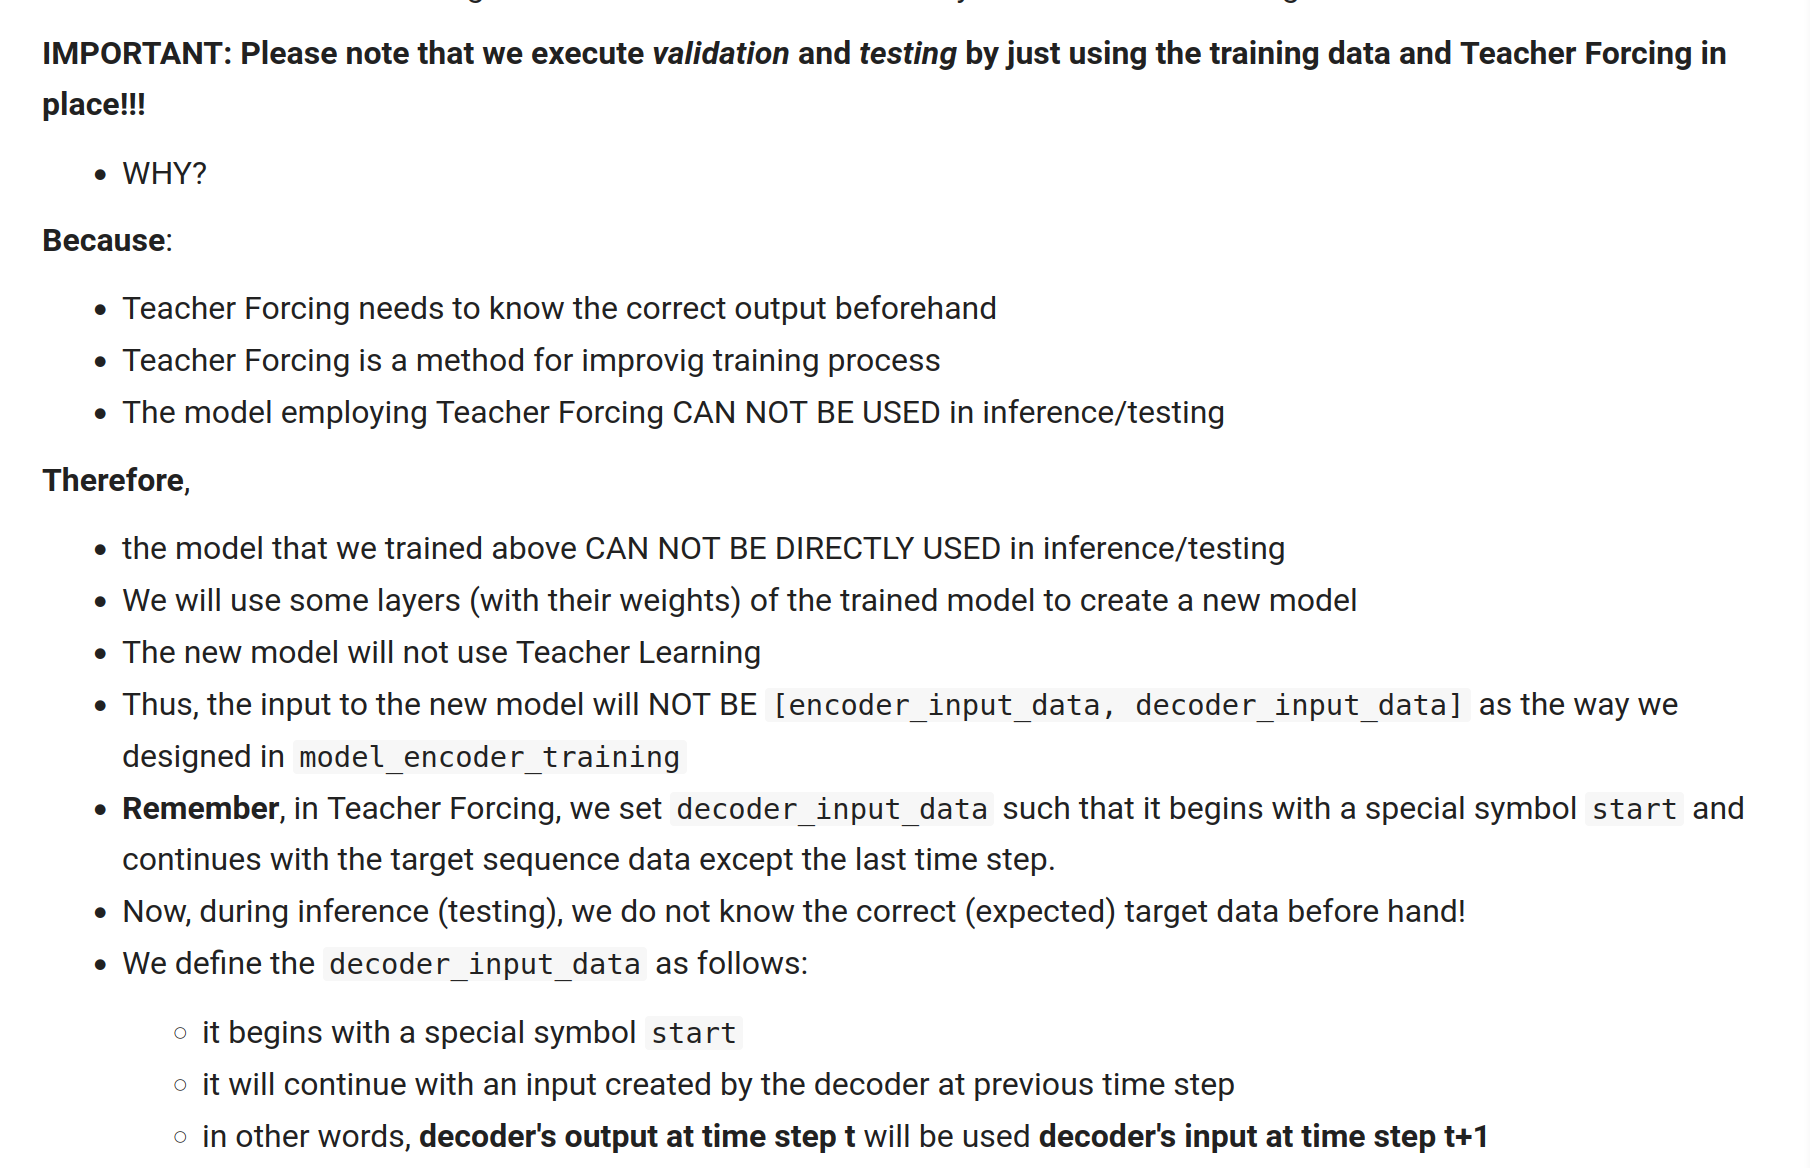

In [17]:
# this layer comes with the trained weights from above since we're recycling
# both encoder_inputs and encoder_states after the have trained.
encoder_model = Model(encoder_inputs, encoder_states) 

decoder_state_input_h = Input(shape=(LSTMoutputDimension,))
decoder_state_input_c = Input(shape=(LSTMoutputDimension,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# note that decoder_lstm has already trained above.
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs,
                                                 initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, 
                      [decoder_outputs] + decoder_states)


In [23]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, n_features))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 1

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_seq = list()
    while not stop_condition:

        # in a loop
        # decode the input to a token/output prediction + required states for context vector
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # convert the token/output prediction to a token/output
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_digit = sampled_token_index
        # add the predicted token/output to output sequence
        decoded_seq.append(sampled_digit)
        

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_digit == '\n' or
           len(decoded_seq) == n_timesteps_in):
            stop_condition = True

        # Update the input target sequence (of length 1) 
        # with the predicted token/output 
        target_seq = np.zeros((1, 1, n_features))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update input states (context vector) 
        # with the ouputed states
        states_value = [h, c]

        # loop back.....
        
    # when loop exists return the output sequence
    return decoded_seq

In [24]:
print('Input \t\t\t  Expected  \t   Predicted \t\tT/F')
correct =0 
sampleNo =  10
for sample in range(0,sampleNo):
  predicted= decode_sequence(encoder_input_data[sample].reshape(1,n_timesteps_in,n_features))
  if (one_hot_decode(decoder_predicted_data[sample])== predicted):
    correct+=1
  print( one_hot_decode(encoder_input_data[sample]), '\t\t', 
        one_hot_decode(decoder_predicted_data[sample]),'\t', predicted,
        '\t\t',one_hot_decode(decoder_predicted_data[sample])== predicted)
print('Accuracy: ', correct/sampleNo)

Input 			  Expected  	   Predicted 		T/F
[8, 0, 5, 7] 		 [7, 5, 0, 8] 	 [7, 5, 0, 8] 		 True
[2, 4, 3, 4] 		 [4, 3, 4, 2] 	 [4, 3, 4, 2] 		 True
[1, 6, 8, 1] 		 [1, 8, 6, 1] 	 [1, 8, 6, 1] 		 True
[9, 7, 8, 7] 		 [7, 8, 7, 9] 	 [7, 8, 7, 9] 		 True
[8, 9, 7, 9] 		 [9, 7, 9, 8] 	 [9, 7, 9, 8] 		 True
[5, 9, 1, 3] 		 [3, 1, 9, 5] 	 [3, 1, 9, 5] 		 True
[4, 4, 7, 7] 		 [7, 7, 4, 4] 	 [7, 7, 4, 4] 		 True
[2, 2, 9, 0] 		 [0, 9, 2, 2] 	 [0, 9, 2, 2] 		 True
[6, 1, 7, 2] 		 [2, 7, 1, 6] 	 [2, 7, 1, 6] 		 True
[3, 0, 7, 3] 		 [3, 7, 0, 3] 	 [3, 7, 0, 3] 		 True
Accuracy:  1.0
